# Intrinsic analysis for VLA

In [1]:
from open_file import load_feature, get_layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Core questions:

1. 특정 state에서 다른 subgoal을 요구하는 natural language instruction이 주어졌을 때, vision language feature가 서로 구별되는가 (다른가)?
- ex1. red coke can을 잡고 있는 상태에서 "pick up the red coke can and place it to metal trash bin" 과 "pick up the red coke can and place it to plastic trash bin"은 다른가?
- ex2. red coke can을 잡고 있는 상태에서 "pick up the red coke can and place it to metal trash bin" 과 green PET bottle을 잡고 있는 상태에서 "pick up the green PET bottle and put it inside the metal trash bin" 은 비슷한가?

2. sufficiency: 같은 subgoal 이지만 (e.g., pick up red coke can), 필요한 action이 다를 때 (e.g., position of red coke can is different), 이런 spatial 한 차이를 제대로 encode를 하는가?
- ex1. red coke can이 왼쪽에 있는 상황에서 "pick up red coke can and place it to metal trash bin" 이라고 하는 거랑, red coke can이 오른쪽에 있는 상황에서 "pick up red coke can and place it to metal trash bin" 이라고 하는 거랑 다르게 인코딩이 되는지?

# Model: trained using seen instruction via flow-matching loss

In [2]:
layer = "action_head.vl_self_attention.layer_3_step_0"

# anchor
after_pickup_can_pnp_can_to_metal = load_feature(
    "/home/dongjun/gr00t_svcca/cached_features/model_seen_depth_1_fusion_action_head_single_vl_feature-checkpoint-10000_dataset_dongjun_251211_validation_after_pickup_red_can_pnp_can_to_metal.hdf5", 
    layer)

# negative
after_pickup_can_pnp_can_to_plastic = load_feature(
    "/home/dongjun/gr00t_svcca/cached_features/model_seen_depth_1_fusion_action_head_single_vl_feature-checkpoint-10000_dataset_dongjun_251211_validation_after_pickup_red_can_pnp_can_to_plastic.hdf5", 
    layer)

# positive
after_pickup_pet_pnp_pet_to_metal = load_feature(
   "/home/dongjun/gr00t_svcca/cached_features/model_seen_depth_1_fusion_action_head_single_vl_feature-checkpoint-10000_dataset_dongjun_251211_validation_after_pickup_green_PET_pnp_pet_to_metal.hdf5",
    layer
)

print("Loaded features")

Loaded features


### Cluster analysis

Start t-SNE visualization


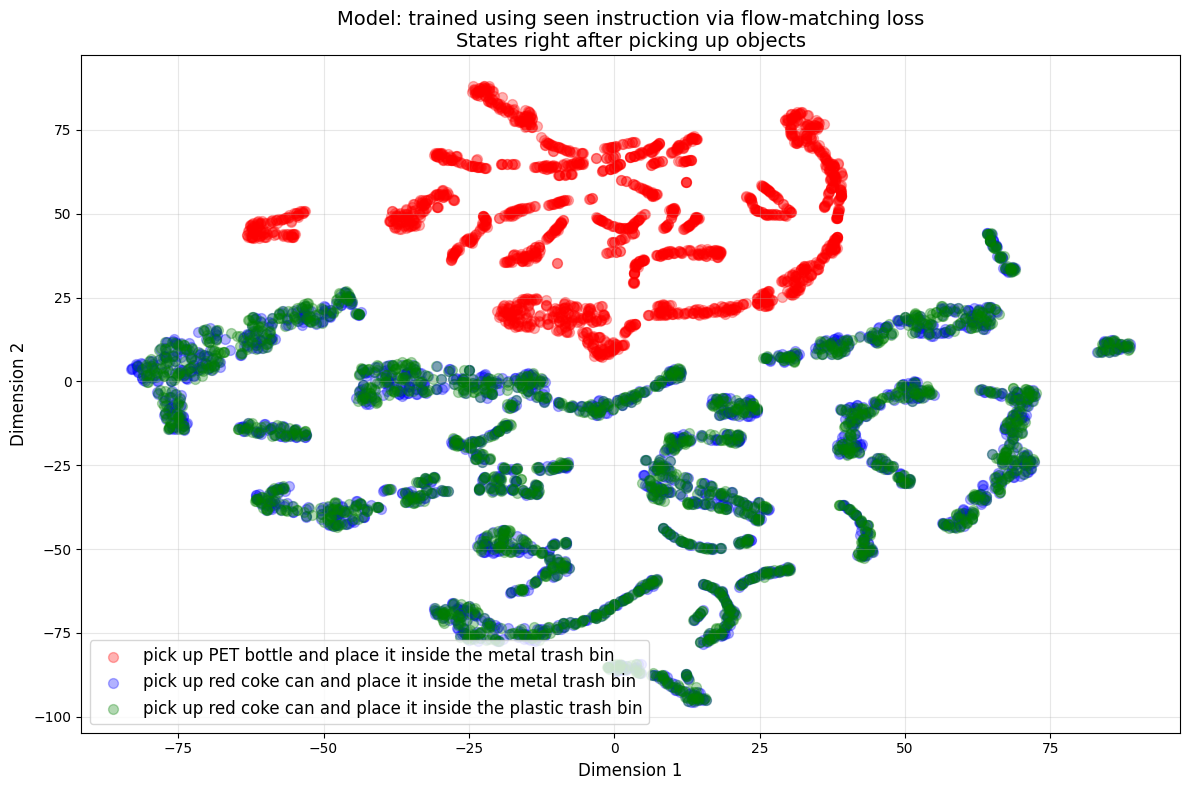

In [11]:
print("Start t-SNE visualization")

# 1. 데이터 합치기
data = np.vstack([
    after_pickup_pet_pnp_pet_to_metal,
    after_pickup_can_pnp_can_to_metal,
    after_pickup_can_pnp_can_to_plastic
])

# 2. 라벨 생성 (색상 구분용)
labels = np.array(
    ['pick up PET bottle and place it inside the metal trash bin'] * len(after_pickup_pet_pnp_pet_to_metal) +
    ['pick up red coke can and place it inside the metal trash bin'] * len(after_pickup_can_pnp_can_to_metal) +
    ['pick up red coke can and place it inside the plastic trash bin'] * len(after_pickup_can_pnp_can_to_plastic)
)

# 3. 차원 축소 (방법 선택)
# 방법 A: t-SNE
reducer = TSNE(n_components=2, random_state=42, perplexity=30)
# 방법 B: UMAP (더 빠름)
# reducer = UMAP(n_components=2, random_state=42)
# 방법 C: PCA (가장 빠름)
# reducer = PCA(n_components=2)

embedded = reducer.fit_transform(data)

# 4. 시각화
plt.figure(figsize=(12, 8))
colors = {'pick up PET bottle and place it inside the metal trash bin': 'red', 
          'pick up red coke can and place it inside the metal trash bin': 'blue', 
          'pick up red coke can and place it inside the plastic trash bin': 'green'}

for label, color in colors.items():
    mask = labels == label
    plt.scatter(
        embedded[mask, 0], 
        embedded[mask, 1], 
        c=color, 
        label=label, 
        alpha=0.3, 
        s=50
    )

plt.legend(fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.title('Model: trained using seen instruction via flow-matching loss\nStates right after picking up objects', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### PCA visualization (on image features)

### Cosine similarity

In [ ]:
import torch
import torch.nn.functional as F

sim_mat = np.zeros((3, 3))

# compute sim between anchor and negative
after_pickup_can_pnp_can_to_metal = F.normalize(torch.tensor(after_pickup_can_pnp_can_to_metal).cuda(), dim=1)
after_pickup_can_pnp_can_to_plastic = F.normalize(torch.tensor(after_pickup_can_pnp_can_to_plastic).cuda(), dim=1)
out = torch.matmul(after_pickup_can_pnp_can_to_metal, after_pickup_can_pnp_can_to_plastic.T)
print(out.mean())

# compute sim between anchor and positive
after_pickup_can_pnp_can_to_metal = F.normalize(torch.tensor(after_pickup_can_pnp_can_to_metal).cuda(), dim=1)
after_pickup_pet_pnp_pet_to_metal = F.normalize(torch.tensor(after_pickup_pet_pnp_pet_to_metal).cuda(), dim=1)
out = torch.matmul(after_pickup_can_pnp_can_to_metal, after_pickup_pet_pnp_pet_to_metal.T)
print(out.mean())

tensor(0.9331, device='cuda:0', dtype=torch.float16)
tensor(0.8989, device='cuda:0', dtype=torch.float16)


/tmp/ipykernel_2047233/973214903.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after_pickup_can_pnp_can_to_metal = F.normalize(torch.tensor(after_pickup_can_pnp_can_to_metal).cuda(), dim=1)
/tmp/ipykernel_2047233/973214903.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after_pickup_can_pnp_can_to_plastic = F.normalize(torch.tensor(after_pickup_can_pnp_can_to_plastic).cuda(), dim=1)
/tmp/ipykernel_2047233/973214903.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after_pickup_can_pnp_can_to_metal = F.normalize(torch.tensor(a

## conclusion:
* fails to understand language: encode same subgoal far apart, different subgoal similar
* Dominated by visual features (same visual --picking specific object on hand-- --> encode similarly)

# Model: trained using seen+unseen instruction via flow-matching loss

In [13]:
layer = "action_head.vl_self_attention.layer_3_step_0"

# anchor
after_pickup_can_pnp_can_to_metal = load_feature(
    "/home/dongjun/gr00t_svcca/cached_features/model_seen_unseen_depth_1_fusion_action_head_single_vl_feature-checkpoint-10000_dataset_dongjun_251211_validation_after_pickup_red_can_pnp_can_to_metal.hdf5", 
    layer)

# negative
after_pickup_can_pnp_can_to_plastic = load_feature(
    "/home/dongjun/gr00t_svcca/cached_features/model_seen_unseen_depth_1_fusion_action_head_single_vl_feature-checkpoint-10000_dataset_dongjun_251211_validation_after_pickup_red_can_pnp_can_to_plastic.hdf5", 
    layer)

# positive
after_pickup_pet_pnp_pet_to_metal = load_feature(
   "/home/dongjun/gr00t_svcca/cached_features/model_seen_unseen_depth_1_fusion_action_head_single_vl_feature-checkpoint-10000_dataset_dongjun_251211_validation_after_pickup_green_PET_pnp_pet_to_metal.hdf5",
    layer
)

print("Loaded features")

Loaded features


Start t-SNE visualization


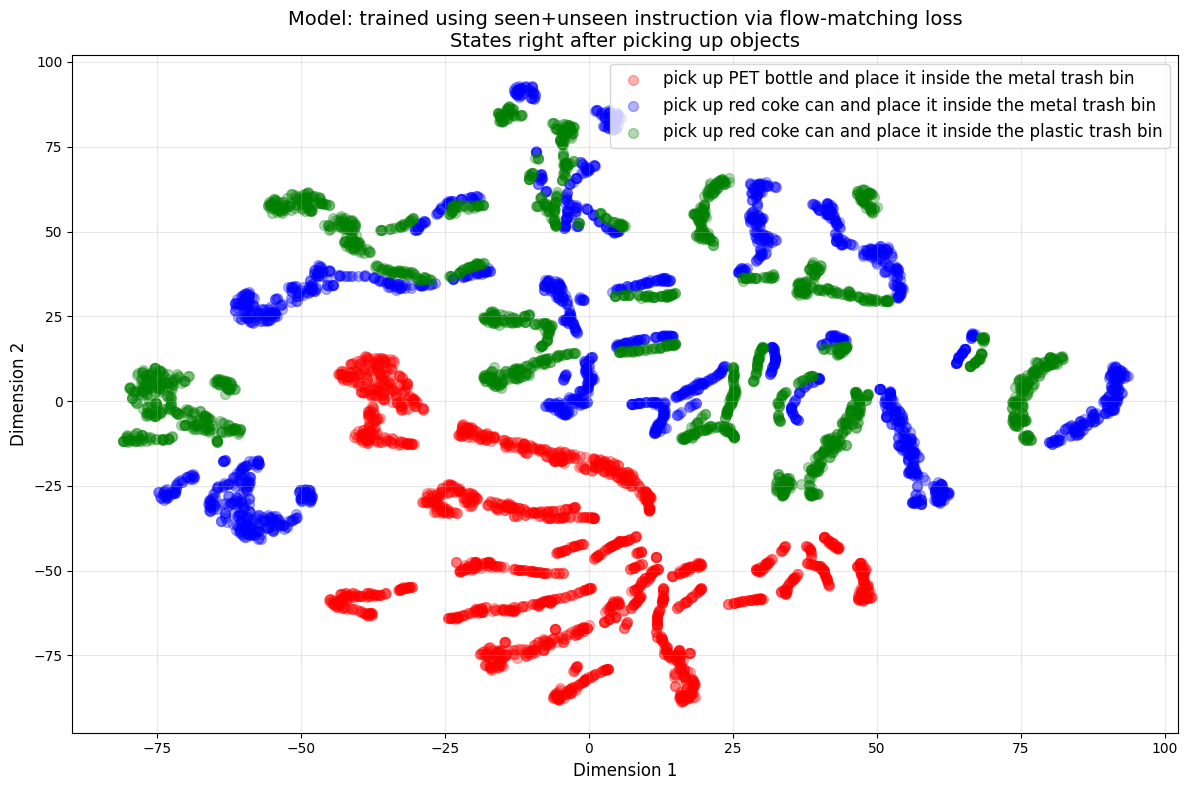

In [15]:
print("Start t-SNE visualization")

# 1. 데이터 합치기
data = np.vstack([
    after_pickup_pet_pnp_pet_to_metal,
    after_pickup_can_pnp_can_to_metal,
    after_pickup_can_pnp_can_to_plastic
])

# 2. 라벨 생성 (색상 구분용)
labels = np.array(
    ['pick up PET bottle and place it inside the metal trash bin'] * len(after_pickup_pet_pnp_pet_to_metal) +
    ['pick up red coke can and place it inside the metal trash bin'] * len(after_pickup_can_pnp_can_to_metal) +
    ['pick up red coke can and place it inside the plastic trash bin'] * len(after_pickup_can_pnp_can_to_plastic)
)

# 3. 차원 축소 (방법 선택)
# 방법 A: t-SNE
reducer = TSNE(n_components=2, random_state=42, perplexity=30)
# 방법 B: UMAP (더 빠름)
# reducer = UMAP(n_components=2, random_state=42)
# 방법 C: PCA (가장 빠름)
# reducer = PCA(n_components=2)

embedded = reducer.fit_transform(data)

# 4. 시각화
plt.figure(figsize=(12, 8))
colors = {'pick up PET bottle and place it inside the metal trash bin': 'red', 
          'pick up red coke can and place it inside the metal trash bin': 'blue', 
          'pick up red coke can and place it inside the plastic trash bin': 'green'}

for label, color in colors.items():
    mask = labels == label
    plt.scatter(
        embedded[mask, 0], 
        embedded[mask, 1], 
        c=color, 
        label=label, 
        alpha=0.3, 
        s=50
    )

plt.legend(fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.title('Model: trained using seen+unseen instruction via flow-matching loss\nStates right after picking up objects', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
import torch
import torch.nn.functional as F

sim_mat = np.zeros((3, 3))

# compute sim between anchor and negative
after_pickup_can_pnp_can_to_metal = F.normalize(torch.tensor(after_pickup_can_pnp_can_to_metal).cuda(), dim=1)
after_pickup_can_pnp_can_to_plastic = F.normalize(torch.tensor(after_pickup_can_pnp_can_to_plastic).cuda(), dim=1)
out = torch.matmul(after_pickup_can_pnp_can_to_metal, after_pickup_can_pnp_can_to_plastic.T)
print(out.mean())

# compute sim between anchor and positive
after_pickup_can_pnp_can_to_metal = F.normalize(torch.tensor(after_pickup_can_pnp_can_to_metal).cuda(), dim=1)
after_pickup_pet_pnp_pet_to_metal = F.normalize(torch.tensor(after_pickup_pet_pnp_pet_to_metal).cuda(), dim=1)
out = torch.matmul(after_pickup_can_pnp_can_to_metal, after_pickup_pet_pnp_pet_to_metal.T)
print(out.mean())

tensor(0.9185, device='cuda:0', dtype=torch.float16)
tensor(0.9014, device='cuda:0', dtype=torch.float16)


/tmp/ipykernel_2047233/3929040620.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after_pickup_can_pnp_can_to_metal = F.normalize(torch.tensor(after_pickup_can_pnp_can_to_metal).cuda(), dim=1)


# SVCCA analysis

In [19]:
from svcca import get_cca_similarity

In [18]:
layer = "action_head.vl_self_attention.layer_3_step_0"

after_pickup_can_pnp_can_to_metal = load_feature(
    "/home/dongjun/gr00t_svcca/cached_features/model_gr00t_3_objs_separation_seen_fusion_action_head_single_vl_feature_ca_batch_for_info_nce_loss_1.0-checkpoint-10000_dataset_dongjun_251211_validation_after_pickup_red_can_pnp_can_to_metal.hdf5", 
    layer)
after_pickup_can_pnp_can_to_plastic = load_feature(
    "/home/dongjun/gr00t_svcca/cached_features/model_gr00t_3_objs_separation_seen_fusion_action_head_single_vl_feature_ca_batch_for_info_nce_loss_1.0-checkpoint-10000_dataset_dongjun_251211_validation_after_pickup_red_can_pnp_can_to_plastic.hdf5", 
    layer)

after_pickup_pet_pnp_pet_to_plastic = load_feature(
    "/home/dongjun/gr00t_svcca/cached_features/model_gr00t_3_objs_separation_seen_fusion_action_head_single_vl_feature_ca_batch_for_info_nce_loss_1.0-checkpoint-10000_dataset_dongjun_251211_validation_after_pickup_green_PET_pnp_pet_to_plastic.hdf5",
    layer
)


after_pickup_pet_pnp_pet_to_plastic = after_pickup_pet_pnp_pet_to_plastic[:, -1, :].transpose(1, 0)
after_pickup_can_pnp_can_to_metal = after_pickup_can_pnp_can_to_metal[:, -1, :].transpose(1, 0)
after_pickup_can_pnp_can_to_plastic = after_pickup_can_pnp_can_to_plastic[:, -1, :].transpose(1, 0)

# comparison to negative
return_dict_2 = get_cca_similarity(
            after_pickup_can_pnp_can_to_metal, after_pickup_can_pnp_can_to_plastic, 
            threshold=0.98, 
            epsilon=1e-6, 
            compute_dirns=False,  # Set to False for faster computation if directions not needed
            device='cuda',
            use_svcca=False,  # Use true SVCCA from paper (SVD preprocessing)
            svd_components=None  # Auto: keep 98% variance
        )

NameError: name 'get_cca_similarity' is not defined

In [ ]:
# comparison to negative
return_dict_2 = get_cca_similarity(
            after_pickup_can_pnp_can_to_metal, after_pickup_can_pnp_can_to_plastic, 
            threshold=0.98, 
            epsilon=1e-6, 
            compute_dirns=False,  # Set to False for faster computation if directions not needed
            device='cuda',
            use_svcca=False,  # Use true SVCCA from paper (SVD preprocessing)
            svd_components=None  # Auto: keep 98% variance
        )

torch.Size([2048, 2048])


---

In [1]:
import os
import sys
# Disable flash attention to avoid ABI compatibility issues
# Add gr00t to path if needed
gr00t_path = "/home/dongjun/GR00T_Training"
if gr00t_path not in sys.path:
    sys.path.insert(0, gr00t_path)

import torch
from torch.utils.data import DataLoader
from transformers.feature_extraction_utils import BatchFeature
from gr00t.model.gr00t_n1 import GR00T_N1_5
from gr00t.model.transforms import build_eagle_processor
from gr00t.model.backbone.eagle_backbone import DEFAULT_EAGLE_PATH
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.data.schema import EmbodimentTag
from gr00t.data.dataset import LeRobotMixtureDataset, LeRobotSingleDataset
from gr00t.model.transforms import DefaultDataCollator
from gr00t.model.transforms import collate

/home/dongjun/miniconda/envs/gr00t/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-02 22:54:25.704447: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 22:54:25.748788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 22:54:25.748824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 22:54

In [2]:
# LLM attention weights extraction only
from typing import Dict, Optional
from collections import OrderedDict


class LLMAttentionExtractor:
    """
    Extract attention weights from LLM layers in GR00T model.
    """
    
    def __init__(self, model):
        """
        Args:
            model: GR00T_N1_5 model instance
        """
        self.model = model
        self.attentions = OrderedDict()
        self.hooks = []
        self.step_counters = {}
        
    def _create_attention_hook(self, name: str):
        """Create a forward hook for self_attn to extract attention weights."""
        def hook(module, input, output):
            if name not in self.step_counters:
                self.step_counters[name] = 0
            
            step_name = f"{name}_step_{self.step_counters[name]}"
            
            # output = (hidden_states, attention_weights, ...)
            self.attentions[step_name] = (output[0].detach(), output[1].detach())
            #if isinstance(output, tuple) and len(output) >= 2:
            #    attn_weights = output[1]
            #     if attn_weights is not None and isinstance(attn_weights, torch.Tensor):
            #        self.attentions[step_name] = attn_weights.detach()
            
            self.step_counters[name] += 1
        return hook
    
    def register_hooks(self):
        """Register forward hooks on LLM self_attn layers."""
        self.clear_hooks()
        self.attentions.clear()
        
        # Enable output_attentions
        self.model.backbone.eagle_model.language_model.config.output_attentions = True
        
        # Language Model layers
        llm_layers = self.model.backbone.eagle_model.language_model.model.layers
        for idx, layer in enumerate(llm_layers):
            hook_name = f"llm.layer_{idx}"
            hook = layer.self_attn.register_forward_hook(
                self._create_attention_hook(hook_name)
            )
            self.hooks.append(hook)
            print(f"Registered attention hook: {hook_name}")
        
        print(f"\nTotal hooks registered: {len(self.hooks)}")
        return self
    
    def clear_hooks(self):
        """Remove all registered hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
    
    def get_attentions(self) -> Dict[str, torch.Tensor]:
        """
        Get the extracted attention weights.
        
        Returns:
            Dict mapping layer names to attention weight tensors.
            Keys: "llm.layer_{idx}.attn_step_{step}"
            Shape: (batch_size, num_heads, seq_len, seq_len)
        """
        return self.attentions.copy()
    
    def clear_attentions(self):
        """Clear stored attention weights to free memory."""
        self.attentions.clear()
        self.step_counters.clear()
    
    def __enter__(self):
        """Context manager entry - registers hooks."""
        self.register_hooks()
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        """Context manager exit - removes hooks."""
        self.clear_hooks()
        self.clear_attentions()



def extract_features_from_forward(model, inputs: dict) -> Dict[str, torch.Tensor]:
    """
    Convenience function to extract features during a single forward pass.
    
    Args:
        model: GR00T_N1_5 model instance
        inputs: Input dictionary for the model
        extractor: (Optional) Pre-initialized IntermediateFeatureExtractor instance.
                   If None, creates a new one (less efficient for repeated calls).
        
    Returns:
        Dictionary of intermediate features from all transformer layers
        
    Example (one-time extraction):
        ```python
        from feature_extraction_utils import extract_features_from_forward
        
        # Run model and extract features
        features = extract_features_from_forward(model, inputs)
        
        # Access features
        for layer_name, feature_tensor in features.items():
            print(f"{layer_name}: {feature_tensor.shape}")
        ```
    
    Example (repeated extraction - more efficient):
        ```python
        from feature_extraction_utils import IntermediateFeatureExtractor, extract_features_from_forward
        
        # Create extractor once and reuse
        extractor = IntermediateFeatureExtractor(model)
        extractor.register_hooks()  # Register hooks once
        
        for batch in dataloader:
            # Reuse extractor for each batch (more efficient)
            features = extract_features_from_forward(model, batch, extractor=extractor)
            # Process features...
            extractor.clear_features()  # Clear to free memory
        
        extractor.clear_hooks()  # Clean up when done
        ```
    """
    extractor = LLMAttentionExtractor(model)
    
    with extractor:
        # Run forward pass
        _ = model.get_action(inputs)
        # Get extracted features
        features = extractor.get_attentions()
    
    return features

In [3]:
# load model and processor
model_seen = GR00T_N1_5.from_pretrained(
        pretrained_model_name_or_path="/home/dongjun/checkpoints/gr00t_3_objs_separation_seen_depth_1_fullft/checkpoint-10000",
        tune_llm=True,  # backbone's LLM
        tune_visual=True,  # backbone's vision tower
        tune_projector=False,  # action head's projector
        tune_diffusion_model=False,  # action head's DiT
        torch_dtype=torch.bfloat16,
    )
model = model_seen.to("cuda")
model_seen.eval()  # Set to evaluation mode (disable dropout, etc.)
    
# Get EAGLE VLM backbone
#eagle_model = model.backbone.eagle_mode

Loading pretrained dual brain from /home/dongjun/checkpoints/gr00t_3_objs_separation_seen_depth_1_fullft/checkpoint-10000
Tune backbone vision tower: True
Tune backbone LLM: True
Tune action head projector: False
Tune action head DiT: False
Model not found or avail in the huggingface hub. Loading from local path: /home/dongjun/checkpoints/gr00t_3_objs_separation_seen_depth_1_fullft/checkpoint-10000
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.20s/it]


Tune backbone llm: True
Tune backbone visual: True
Tune action head projector: False
Tune action head diffusion model: False
Action head trainable parameter: future_tokens.weight
Action head trainable parameter: vlln.weight
Action head trainable parameter: vlln.bias
Action head trainable parameter: vl_self_attention.transformer_blocks.0.norm1.weight
Action head trainable parameter: vl_self_attention.transformer_blocks.0.norm1.bias
Action head trainable parameter: vl_self_attention.transformer_blocks.0.attn1.to_q.weight
Action head trainable parameter: vl_self_attention.transformer_blocks.0.attn1.to_q.bias
Action head trainable parameter: vl_self_attention.transformer_blocks.0.attn1.to_k.weight
Action head trainable parameter: vl_self_attention.transformer_blocks.0.attn1.to_k.bias
Action head trainable parameter: vl_self_attention.transformer_blocks.0.attn1.to_v.weight
Action head trainable parameter: vl_self_attention.transformer_blocks.0.attn1.to_v.bias
Action head trainable parameter

GR00T_N1_5(
  (backbone): EagleBackbone(
    (eagle_model): Eagle2_5_VLForConditionalGeneration(
      (vision_model): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              

In [4]:
  # Get eagle processor
eagle_processor = build_eagle_processor(
'/home/dongjun/GR00T_Training/gr00t/model/backbone/eagle2_hg_model',
)
eagle_processor.tokenizer.padding_side = "left"

In [5]:
# get dataset
data_config_cls = DATA_CONFIG_MAP["bimanual_piper"]
modality_configs = data_config_cls.modality_config()
transforms = data_config_cls.transform()
embodiment_tag = EmbodimentTag("new_embodiment")

train_dataset = LeRobotSingleDataset(
    dataset_path="/home/dongjun/gr00t_svcca/dataset/segmented_depth_1_trash_separation_3_objs_unseen_251126_pnp_coke_to_plastic_place_split",
    modality_configs=modality_configs,
    transforms=transforms,
    embodiment_tag=embodiment_tag,  # This will override the dataset's embodiment tag to "new_embodiment"
    video_backend="torchvision_av",
    )

Initialized dataset segmented_depth_1_trash_separation_3_objs_unseen_251126_pnp_coke_to_plastic_place_split with EmbodimentTag.NEW_EMBODIMENT


In [6]:
sample = next(iter(train_dataset))
inputs = collate([sample], eagle_processor)

In [7]:
out = extract_features_from_forward(model_seen, inputs)

Registered attention hook: llm.layer_0
Registered attention hook: llm.layer_1
Registered attention hook: llm.layer_2
Registered attention hook: llm.layer_3
Registered attention hook: llm.layer_4
Registered attention hook: llm.layer_5
Registered attention hook: llm.layer_6
Registered attention hook: llm.layer_7
Registered attention hook: llm.layer_8
Registered attention hook: llm.layer_9
Registered attention hook: llm.layer_10
Registered attention hook: llm.layer_11

Total hooks registered: 12


In [8]:
attn_maps = []
for v in out.values():
    attn_maps.append(v[1])

In [10]:
import torch

def attention_rollout_last_token(attn_layers, add_residual=True):
    """
    Compute attention rollout for the final token's representation.

    Args:
        attn_layers:
            - Tensor of shape (L, 1, H, S, S) or (L, H, S, S), or
            - list of Tensors, each of shape (1, H, S, S)
        add_residual: whether to mix attention with identity (residual connection).

    Returns:
        last_token_importance: Tensor of shape (S,)
            Rollout-based importance of each input token for the final token
            in the last layer.
    """
    # Normalize to a single tensor of shape (L, H, S, S)
    if isinstance(attn_layers, torch.Tensor):
        if attn_layers.dim() == 5:
            # (L, 1, H, S, S) -> (L, H, S, S)
            attn = attn_layers[:, 0]
        elif attn_layers.dim() == 4:
            # already (L, H, S, S)
            attn = attn_layers
        else:
            raise ValueError(f"Unexpected attn_layers shape: {attn_layers.shape}")
    else:
        # assume list of (1, H, S, S)
        attn = torch.stack([a.squeeze(0) for a in attn_layers], dim=0)

    L, H, S, _ = attn.shape

    # 1) Average over heads: (L, S, S)
    attn_head_avg = attn.mean(dim=1)

    # 2) Add residual by mixing with identity
    eye = torch.eye(S, device=attn_head_avg.device, dtype=attn_head_avg.dtype)
    if add_residual:
        # A_l = 0.5 * W_l + 0.5 * I
        A = 0.5 * attn_head_avg + 0.5 * eye.unsqueeze(0)
    else:
        A = attn_head_avg

    # 3) Rollout: R_0 = I, R_l = A_l @ R_{l-1}
    rollout = eye.clone()  # (S, S)
    for l in range(L):
        rollout = A[l] @ rollout  # (S, S)

    # 4) Take the row for the final token index (S - 1)
    last_token_idx = S - 1
    last_token_importance = rollout[last_token_idx]  # (S,)

    return rollout

In [11]:
rollout_result = attention_rollout_last_token(attn_maps)

In [15]:
sample['eagle_content']['text_list'][0]

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<image-1><image-2><image-3>pick up the red coke can and put it inside the plastic trash bin.<|im_end|>\n<|im_start|>assistant\n'

In [18]:
torch.where(inputs['eagle_input_ids'] == 151671)

(tensor([0, 0, 0]), tensor([276, 539, 802]))

<BarContainer object of 822 artists>

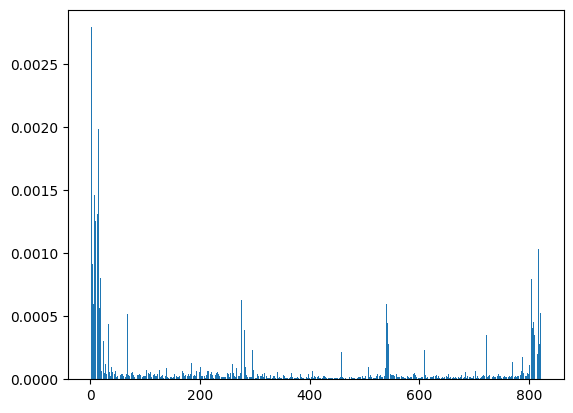

In [14]:
import matplotlib.pyplot as plt

plt.bar(range(1, len(rollout_result[822].cpu().float().numpy())), rollout_result[822,1:].cpu().float().numpy())

In [14]:
out['llm.layer_0.attn_step_0'].shape

torch.Size([1, 823, 2048])

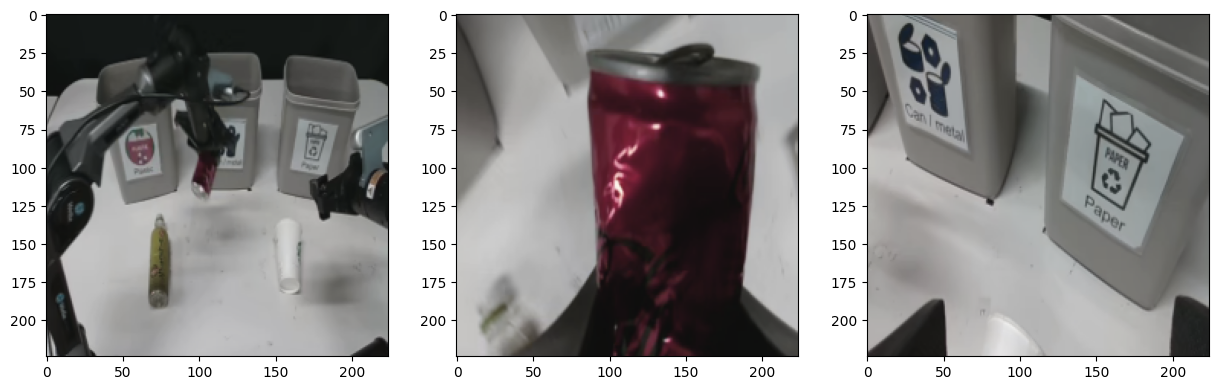

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample['eagle_content']['image_inputs'][0])
plt.subplot(1, 3, 2)
plt.imshow(sample['eagle_content']['image_inputs'][1])
plt.subplot(1, 3, 3)
plt.imshow(sample['eagle_content']['image_inputs'][2])
plt.show()

# Q. Does the final hidden state become different according to slight change in language instruction?

In [51]:
sample['eagle_content']['text_list'][0]

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<image-1><image-2><image-3>pick up the red coke can and put it inside the plastic trash bin.<|im_end|>\n<|im_start|>assistant\n'

In [ ]:
sample = next(iter(train_dataset))

sample_1 = sample.copy()
sample_2 = sample.copy()
sample_2['eagle_content']['text_list'][0] = "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<image-1><image-2><image-3>pick up the red coke can and put it inside the metal trash bin.<|im_end|>\n<|im_start|>assistant\n" 
inputs = collate([sample], eagle_processor)

In [42]:
out = extract_features_from_forward(model, inputs)

Registered attention hook: llm.layer_0
Registered attention hook: llm.layer_1
Registered attention hook: llm.layer_2
Registered attention hook: llm.layer_3
Registered attention hook: llm.layer_4
Registered attention hook: llm.layer_5
Registered attention hook: llm.layer_6
Registered attention hook: llm.layer_7
Registered attention hook: llm.layer_8
Registered attention hook: llm.layer_9
Registered attention hook: llm.layer_10
Registered attention hook: llm.layer_11

Total hooks registered: 12


In [50]:
out['llm.layer_11_step_0'][0]

tensor([[[ 0.1270,  0.1406, -0.1177,  ...,  0.2734,  0.0483, -0.0098],
         [ 0.2227,  0.6289, -0.2773,  ..., -0.3887,  0.4434,  0.3984],
         [ 0.1318,  0.3809, -0.3496,  ..., -0.0400,  0.2812,  0.1689],
         ...,
         [ 0.6914,  1.7500, -0.6523,  ..., -0.3320,  0.6328, -0.3535],
         [-0.0299,  0.9805, -0.1621,  ..., -0.3535,  0.7148, -0.2578],
         [-0.0869,  0.5195, -0.3945,  ..., -0.0393,  0.3730, -0.3145]]],
       device='cuda:0', dtype=torch.bfloat16)